In [1]:
import h5py
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from collections import defaultdict

2024-01-19 13:42:55.251321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 13:42:55.251354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 13:42:55.252406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 13:42:55.258245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 13:42:56.066538: W tensorflow/compiler/tf2

In [2]:
from data_processing import Data_retrieval_and_processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut


train_data = Data_retrieval_and_processing("Data/Cross/train")
test_data1 = Data_retrieval_and_processing("Data/Cross/test1")
test_data2 = Data_retrieval_and_processing("Data/Cross/test2")
test_data3 = Data_retrieval_and_processing("Data/Cross/test3")

x_train = train_data.processed_matrices
y_train = train_data.one_hot_encoded_labels
x_test = np.concatenate([test_data1.processed_matrices, test_data2.processed_matrices, test_data3.processed_matrices])
y_test = np.concatenate([test_data1.one_hot_encoded_labels, test_data2.one_hot_encoded_labels, test_data3.one_hot_encoded_labels])

x_train, y_train = shuffle(x_train, y_train, random_state = 42)
x_test, y_test = shuffle(x_test, y_test, random_state = 42)

del train_data, test_data1, test_data2, test_data3

In [3]:
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
batch_size = 4

model = keras.Sequential([
    layers.Bidirectional(layers.LSTM(500, return_sequences = True, recurrent_initializer = 'glorot_uniform', stateful = False, recurrent_regularizer = "l2"), batch_input_shape = (batch_size, *x_train.shape[1:])),
    layers.Bidirectional(layers.LSTM(250, return_sequences = False, recurrent_initializer = 'glorot_uniform', stateful = False, recurrent_regularizer = "l2"), batch_input_shape = (batch_size, *x_train.shape[1:])),
    layers.Dense(y_train.shape[1], activation = "softmax")]
)

print(model.summary())

# lr = 1e-7/3e-7
optimizer = Adam(learning_rate = 1e-4)
model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ['accuracy'])

2024-01-19 13:42:58.826989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-19 13:42:58.867285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-19 13:42:58.867544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (4, 248, 1000)            19816000  
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (4, 500)                  2502000   
 onal)                                                           
                                                                 
 dense (Dense)               (4, 4)                    2004      
                                                                 
Total params: 22320004 (85.14 MB)
Trainable params: 22320004 (85.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [4]:
import sys

def generate_val_batch(x_train, y_train, folds):
    val_idx = 0
    for val_idx in range(folds):
        yield np.delete(x_train, val_idx, 0), np.delete(y_train, val_idx, 0), x_train[val_idx], y_train[val_idx]

def train_batches(model, epochs, x_train_all, y_train_all):
    history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
    for epoch in range(epochs):
        running_metrics = defaultdict(int)
        val_idx = 0
        for batch in generate_val_batch(x_train_all, y_train_all, x_train_all.shape[0]): # training + validation run
            x_train, y_train, x_validation, y_validation = batch

            for idx, (x_batch, y_batch) in enumerate(zip(x_train, y_train)):
                x_batch, y_batch = x_batch.reshape(1,*x_batch.shape), y_batch.reshape(1,*y_batch.shape)
                train_metrics = model.train_on_batch(x_batch, y_batch, return_dict = True)
                for metric, value in train_metrics.items():
                    running_metrics[metric] = running_metrics[metric] * (idx/(idx+1)) + value/(idx+1)

                for metric, value in train_metrics.items():
                        running_metrics[metric] = running_metrics[metric] * (idx/(idx+1)) + value/(idx+1)

            x_validation, y_validation = x_validation.reshape(1,*x_validation.shape), y_validation.reshape(1,*y_validation.shape)
            val_metrics = model.test_on_batch(x_validation, y_validation, return_dict = True)
            running_metrics["val_loss"] = running_metrics["val_loss"] * (val_idx/(val_idx+1)) + val_metrics["loss"]/(val_idx+1)
            running_metrics["val_accuracy"] = running_metrics["val_accuracy"] * (val_idx/(val_idx+1)) + val_metrics["accuracy"]/(val_idx+1)
            val_idx += 1
            sys.stdout.write("\r" + f"Epoch: {epoch+1}/{epochs} - batch: {val_idx}/{x_train_all.shape[0]} - loss: {running_metrics['loss']:0.3f} --- accuracy: {running_metrics['accuracy']:0.3f}" + f" || val loss: {val_metrics['loss']:0.3f} --- val accuracy: {val_metrics['accuracy']:0.3f} --- running val accuracy: {running_metrics['val_accuracy']:0.3f}")
        print()
        history["loss"].append(running_metrics["loss"])
        history["accuracy"].append(running_metrics["accuracy"])
        history["val_loss"].append(running_metrics["val_loss"])
        history["val_accuracy"].append(running_metrics["val_accuracy"])

    return history

epochs = 10
history = train_batches(model, epochs, x_train, y_train)

2024-01-19 13:43:02.819201: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-19 13:43:02.897264: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f46055165b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-19 13:43:02.897285: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-01-19 13:43:02.902590: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-19 13:43:02.933997: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
I0000 00:00:1705668182.986884  586337 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 1/10 - batch: 64/64 - loss: 0.781 --- accuracy: 0.686 || val loss: 0.659 --- val accuracy: 1.000 --- running val accuracy: 0.5310
Epoch: 2/10 - batch: 64/64 - loss: 0.651 --- accuracy: 0.676 || val loss: 0.708 --- val accuracy: 1.000 --- running val accuracy: 0.750
Epoch: 3/10 - batch: 64/64 - loss: 0.554 --- accuracy: 0.754 || val loss: 0.520 --- val accuracy: 1.000 --- running val accuracy: 0.719
Epoch: 4/10 - batch: 64/64 - loss: 0.457 --- accuracy: 0.791 || val loss: 0.518 --- val accuracy: 1.000 --- running val accuracy: 0.750
Epoch: 5/10 - batch: 64/64 - loss: 0.402 --- accuracy: 0.878 || val loss: 0.475 --- val accuracy: 1.000 --- running val accuracy: 0.781
Epoch: 6/10 - batch: 64/64 - loss: 0.336 --- accuracy: 0.896 || val loss: 0.720 --- val accuracy: 1.000 --- running val accuracy: 0.875
Epoch: 7/10 - batch: 64/64 - loss: 0.453 --- accuracy: 0.868 || val loss: 0.659 --- val accuracy: 1.000 --- running val accuracy: 0.781
Epoch: 8/10 - batch: 64/64 - loss: 0.345 --- ac

In [5]:
model.save("models/lstm_cross.keras")

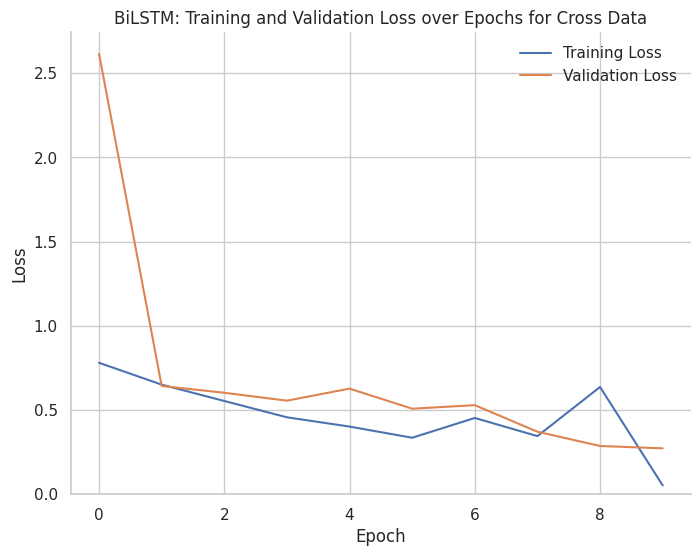

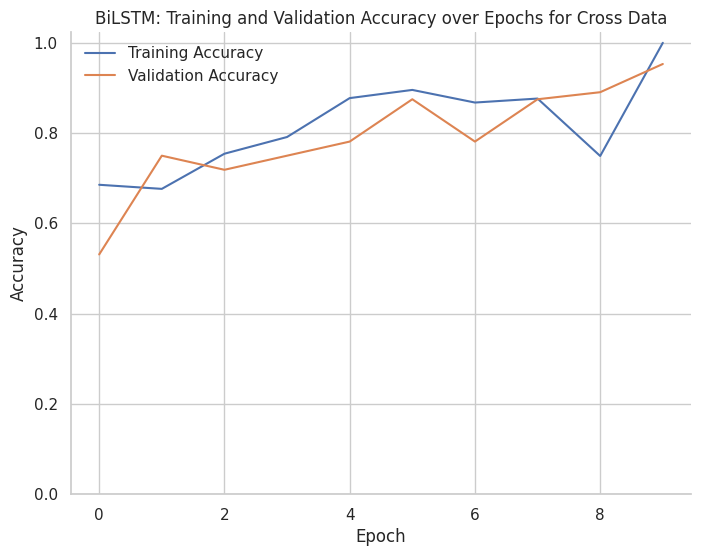

In [6]:
import seaborn as sns

def plot_data(data_1, data_2, title, file_name, type, is_transparent = False):
    sns.set_theme(style = "whitegrid")
    plt.figure(figsize = (8,6))

    plt.plot(data_1, label = f"Training {type}")
    plt.plot(data_2, label = f"Validation {type}")
    plt.ylim(0)

    plt.xlabel("Epoch")
    plt.ylabel(type)
    plt.title(title)
    plt.legend(frameon = False)
    sns.despine()
    plt.savefig("plots/lstm/" + file_name, transparent = is_transparent)
    plt.show()

pickle.dump(history, open(f"results/lstm_cross_{epochs}_results.pickle", "wb"))
plot_data(history["loss"], history["val_loss"], "BiLSTM: Training and Validation Loss over Epochs for Cross Data", f"loss_lstm_cross_{epochs}.png", "Loss", is_transparent = True)
plot_data(history["accuracy"], history["val_accuracy"], "BiLSTM: Training and Validation Accuracy over Epochs for Cross Data", f"acc_lstm_cross_{epochs}.png", "Accuracy", is_transparent = True)

In [7]:
_, acc = model.evaluate(x_test, y_test)
print(acc)

2024-01-19 14:34:27.216042: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 195.92MiB (rounded to 205432832)requested by op CudnnRNN
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-19 14:34:27.216094: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-19 14:34:27.216118: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 43, Chunks in use: 43. 10.8KiB allocated for chunks. 10.8KiB in use in bin. 496B client-requested in use in bin.
2024-01-19 14:34:27.216136: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 512B client-requested in use in bin.
2024-01-19 14:34:27.216153: I ext

InternalError: Graph execution error:

Detected at node CudnnRNN defined at (most recent call last):
<stack traces unavailable>
Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 4453, 500, 1, 248, 32, 500] 
	 [[{{node CudnnRNN}}]]
	 [[sequential/bidirectional/backward_lstm/PartitionedCall]] [Op:__inference_test_function_422984]